In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('dark_background')

data_path = 'Data/co2_mm_gl.csv'
df = pd.read_csv(data_path, comment='#')

print(df.head())

   year  month   decimal  average  average_unc   trend  trend_unc
0  1979      1  1979.042   336.56         0.11  335.92       0.09
1  1979      2  1979.125   337.29         0.09  336.25       0.09
2  1979      3  1979.208   337.88         0.11  336.51       0.09
3  1979      4  1979.292   338.32         0.13  336.72       0.10
4  1979      5  1979.375   338.26         0.04  336.71       0.10


In [2]:
date_components = {
    'year': df['year'],
    'month': df['month'],
    'day': 1  # since data is monthly, we set day to 1
}
df['date'] = pd.to_datetime(date_components)

df.set_index('date', inplace=True)

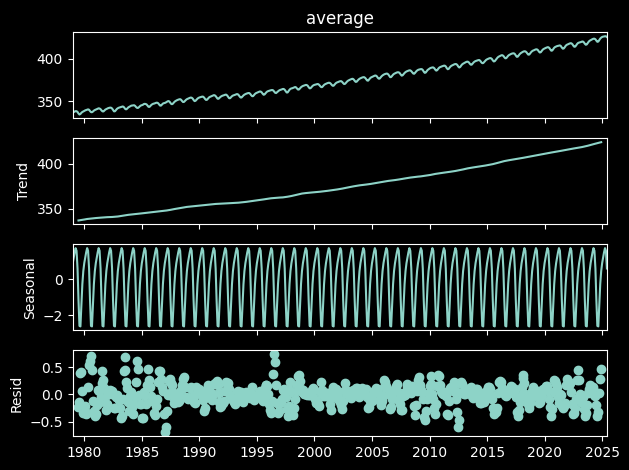

In [3]:
co2_series = df['average']
co2_series_decomposed = seasonal_decompose(co2_series, model='additive', period=12)
fig = co2_series_decomposed.plot()
plt.savefig('Plots/co2_decomposition_raw_output.png')
plt.show()

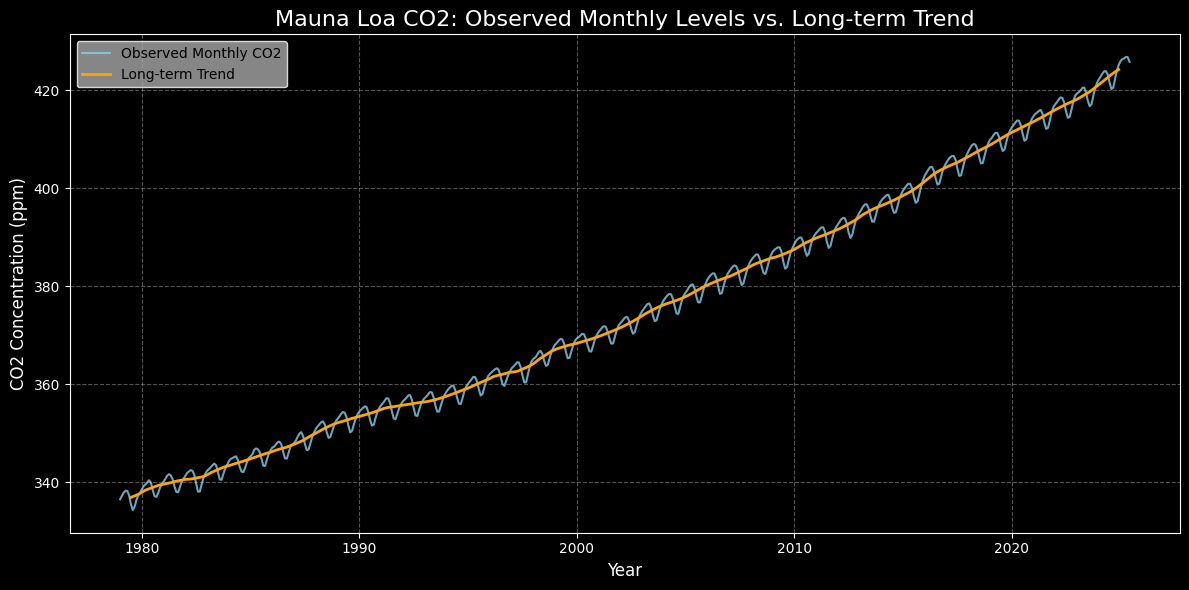

In [4]:
# Raw data + Trend
fig, ax = plt.subplots(figsize=(12,6))
# plot raw data
ax.plot(co2_series.index, co2_series, label='Observed Monthly CO2', color='skyblue', alpha=0.8)
# plot trend component
ax.plot(co2_series_decomposed.trend.index, co2_series_decomposed.trend, label='Long-term Trend', color='orange', linewidth=2)
# add title and labels
ax.set_title('Mauna Loa CO2: Observed Monthly Levels vs. Long-term Trend', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CO2 Concentration (ppm)', fontsize=12)
# customize tick parameters
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# add legend
legend = ax.legend(fontsize=10, facecolor='darkgray', edgecolor='white')
for text in legend.get_texts():
    text.set_color('black')
# add grid for readability
ax.grid(True, linestyle='--', alpha=0.5, color='darkgray')

plt.tight_layout()
plt.savefig('Plots/co2_observed_vs_trend.png', dpi=300, bbox_inches='tight')
plt.show()



/tmp/ipykernel_120863/301797766.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(fontsize=10, facecolor='darkgray', edgecolor='white')


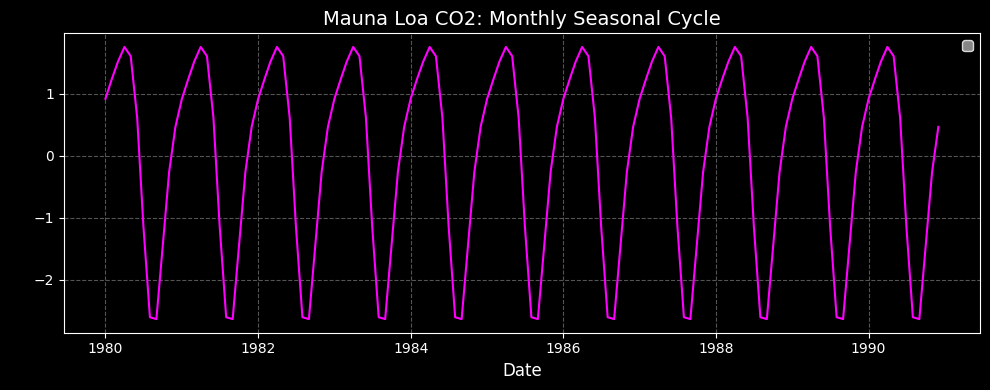

In [5]:
fig, ax = plt.subplots(figsize=(10,4))
# plot seasonal component
ax.plot(co2_series_decomposed.seasonal.loc['1980':'1990'].index, 
        co2_series_decomposed.seasonal.loc['1980':'1990'], 
        color='magenta', linewidth=1.5)
# add title and labels
ax.set_title('Mauna Loa CO2: Monthly Seasonal Cycle', fontsize=14)
ax.set_xlabel('Date', fontsize=12, color='white')
ax.set_ylabel('Seasonal Variation (ppm)', fontsize=12, color='black')
# customize tick parameters
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# add legend
legend = ax.legend(fontsize=10, facecolor='darkgray', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')
# add grid for readability
ax.grid(True, linestyle='--', alpha=0.5, color='darkgray')

plt.tight_layout()
plt.savefig('Plots/co2_seasonal_cycle.png', dpi=300, bbox_inches='tight')
plt.show()

CO2 trend points: 536
Temperature trend points: 536
Date range: 1980-07-01 00:00:00 to 2025-02-01 00:00:00


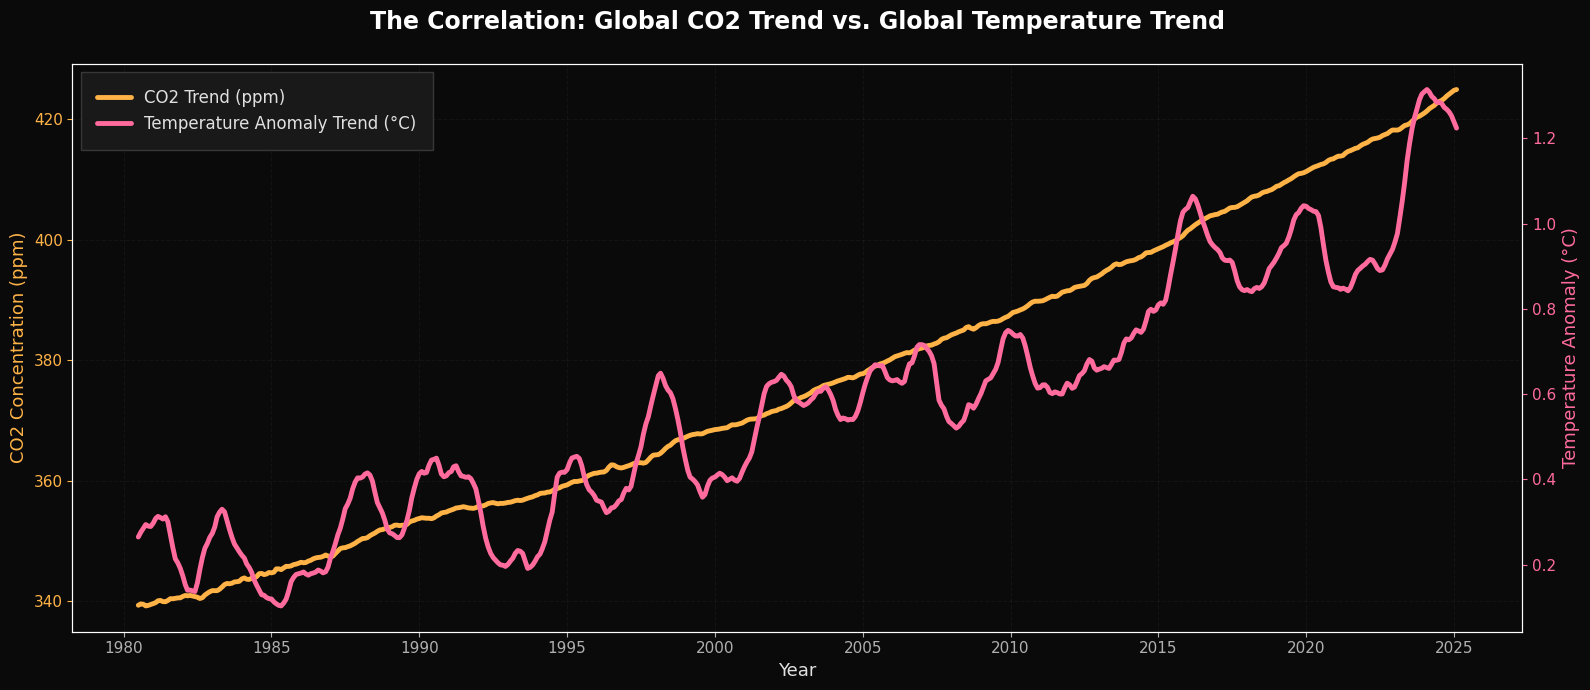

In [6]:
# Load temperature data
df_temp = pd.read_csv('Data/GLB.Ts+dSST.csv', comment='#', na_values='***', index_col=False)

# Load CO2 data (skip comment lines at the top)
df_co2 = pd.read_csv('Data/co2_mm_gl.csv', comment='#', skipinitialspace=True)


# Create datetime index for CO2
df_co2['date'] = pd.to_datetime(df_co2[['year', 'month']].assign(day=1))
co2_series = df_co2.set_index('date')['average']

# Use the pre-calculated trend column from the CO2 dataset
co2_trend_series = df_co2.set_index('date')['trend']


# Melt from wide to long format
month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_temp_long = df_temp.melt(id_vars=['Year'], value_vars=month_columns, 
                             var_name='Month_Name', value_name='Anomaly_C')

# Clean and convert to numeric
df_temp_long['Anomaly_C'] = pd.to_numeric(df_temp_long['Anomaly_C'], errors='coerce')
df_temp_long.dropna(subset=['Anomaly_C'], inplace=True)

# Create datetime index for temperature
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df_temp_long['Month'] = df_temp_long['Month_Name'].map(month_mapping)
df_temp_long['date'] = pd.to_datetime(df_temp_long[['Year', 'Month']].assign(Day=1))

# Convert to time series
temp_series = df_temp_long.set_index('date')['Anomaly_C'].sort_index()

start_date = '1980-01-01'
co2_final = co2_trend_series[co2_trend_series.index >= start_date].dropna()
temp_series_filtered = temp_series[temp_series.index >= start_date]

# Decompose temperature data
temp_series_decomposed = seasonal_decompose(temp_series_filtered, model='additive', period=12)
temp_final = temp_series_decomposed.trend.dropna()

# Align to common dates
common_index = co2_final.index.intersection(temp_final.index)
co2_final = co2_final.loc[common_index]
temp_final = temp_final.loc[common_index]

print(f"CO2 trend points: {len(co2_final)}")
print(f"Temperature trend points: {len(temp_final)}")
print(f"Date range: {co2_final.index.min()} to {co2_final.index.max()}")


fig, ax1 = plt.subplots(figsize=(16, 7))
fig.patch.set_facecolor('#0a0a0a')
ax1.set_facecolor('#0a0a0a')

# Color scheme
color_co2 = '#FFB347'      # Soft orange
color_temp = '#FF6B9D'     # Soft coral pink

# Plot CO2 trend (left y-axis)
ax1.set_xlabel('Year', fontsize=13, color='#e0e0e0', fontweight='500')
ax1.set_ylabel('CO2 Concentration (ppm)', fontsize=13, color=color_co2, fontweight='500')
line1 = ax1.plot(co2_final.index, co2_final, 
                 color=color_co2, linewidth=3.5, label='CO2 Trend',
                 solid_capstyle='round')
ax1.tick_params(axis='y', labelcolor=color_co2, colors=color_co2, labelsize=11)
ax1.tick_params(axis='x', colors='#b0b0b0', labelsize=11)

# Plot Temperature trend (right y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=13, color=color_temp, fontweight='500')
line2 = ax2.plot(temp_final.index, temp_final,
                 color=color_temp, linewidth=3.5, label='Temperature Anomaly Trend',
                 solid_capstyle='round')
ax2.tick_params(axis='y', labelcolor=color_temp, colors=color_temp, labelsize=11)

ax1.grid(True, linestyle='--', alpha=0.15, color='#4a4a4a', linewidth=0.8)
ax1.set_axisbelow(True)

plt.title('The Correlation: Global CO2 Trend vs. Global Temperature Trend', 
          fontsize=17, color='white', pad=25, fontweight='600')

lines = line1 + line2
labels = ['CO2 Trend (ppm)', 'Temperature Anomaly Trend (°C)']
legend = ax1.legend(lines, labels, loc='upper left', fontsize=12,
                   frameon=True, fancybox=False, shadow=False,
                   facecolor='#1a1a1a', edgecolor='#3a3a3a', 
                   framealpha=0.95, borderpad=1)
plt.setp(legend.get_texts(), color='#e0e0e0')

plt.tight_layout()
plt.savefig('Plots/co2_vs_temp_correlation.png', dpi=300, bbox_inches='tight', 
            facecolor='#0a0a0a', edgecolor='none')
plt.show()